# Social Media Analytics

## Webscraping Project

### Introduction to Text Mining

### Topic Modeling Analysis 

Felix Funes 20220306 | Paula Catalan 20221048 | Efstathia Styliagkatzi 20220078 | Alisson Tapia 20221156 | S M Abrar Hossain Asif 20220223

Topic modeling analysis can provide valuable insights like:

Discovering latent themes: Topic modeling allows you to uncover latent themes or topics within a collection of documents. It helps in identifying the underlying patterns and structures in large text datasets without the need for manual reading and categorization of each document.

Understanding large text corpora: When dealing with a large corpus of text data, it can be challenging to gain a comprehensive understanding of the content. Topic modeling helps in summarizing and organizing the textual information into meaningful topics, making it easier to explore and navigate the dataset.

Content recommendation and information retrieval: Topic modeling enables content recommendation systems to suggest relevant items based on the topics extracted from users' preferences or queries. It helps in improving search engines, recommender systems, and personalized content delivery by matching users' interests with relevant topics.

Text clustering and document classification: By assigning documents to different topics, topic modeling enables text clustering and document classification. It aids in grouping similar documents together based on their thematic content, allowing for easier organization, retrieval, and analysis of the text data.

Market research and customer insights: Topic modeling can be applied to customer reviews, feedback, or social media data to identify prevalent topics and sentiments. This helps businesses gain insights into customer preferences, concerns, and trends, aiding in product development, marketing strategies, and customer satisfaction analysis.

Exploratory data analysis: Topic modeling serves as a powerful exploratory data analysis tool. It helps researchers and analysts to gain a quick overview of the main themes present in a text dataset, identify outliers or anomalies, and identify areas for further investigation or research.

### Initial setup

In [1]:
# Import packages
import csv
import pandas as pd
import numpy as np
import nltk 
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import gensim         
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
#import pyLDAvis.gensim

# For pyLDAvis new version - replace the previous line
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


import matplotlib.pyplot as plt

In [2]:
# Just because of versions on my computer
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Load dataset
dtypes = {'device':'category','user':'category','rating':'integer','ownership_lenght':'category'}
ds = pd.read_excel("ExtractedReviewsDataCollection_bestbuy.xlsx", sheet_name="Sheet1", index_col = 0)


### Functions

In [4]:
# Text preprocessing
def textPreProcess(rawText, removeHTML=True, charsToRemove = r'\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-', removeNumbers=True, removeLineBreaks=False, specialCharsToRemove = r'[^\x00-\xfd]', convertToLower=True, removeConsecutiveSpaces=True):
    if type(rawText) != str:
        return rawText
    procText = rawText
        
    # Remove HTML
    if removeHTML:
        procText = BeautifulSoup(procText,'html.parser').get_text()

    # Remove punctuation and other special characters
    if len(charsToRemove)>0:
        procText = re.sub(charsToRemove,' ',procText)

    # Remove numbers
    if removeNumbers:
        procText = re.sub(r'\d+',' ',procText)

    # Remove line breaks
    if removeLineBreaks:
        procText = procText.replace('\n',' ').replace('\r', '')

    # Remove special characters
    if len(specialCharsToRemove)>0:
        procText = re.sub(specialCharsToRemove,' ',procText)

    # Normalize to lower case
    if convertToLower:
        procText = procText.lower() 

    # Replace multiple consecutive spaces with just one space
    if removeConsecutiveSpaces:
        procText = re.sub(' +', ' ', procText)

    return procText

In [5]:
# Tokenize words
def tokenize_words(words):
    if (type(words) != str) or (word_tokenize(words) == ''):
        return np.nan
    else:
        return word_tokenize(words)

In [6]:
# Function to create text from words
def recreateText(words):
    if type(words) == list:
        temp_str = (' ').join(words)
        return temp_str
    else:
        return np.nan

In [7]:
# Function to remove stop words
def removeStopWords(t, stop_words):
    if type(t) == list:
        return [w for w in t if not w in stop_words]
    else:
        return np.nan

In [8]:
# Function to lemmatize words
def lemmatize(words):
    if type(words) == list:
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(x) for x in words]
    else:
        return np.nan

In [9]:
# Load dataset and check column names
dtypes = {'device': 'category', 'user': 'category', 'rating': 'integer', 'ownership_length': 'category'}
ds = pd.read_excel("ExtractedReviewsDataCollection_bestbuy.xlsx", sheet_name="Sheet1", index_col=0)
print(ds.columns)  # Check column names

Index(['device', 'user', 'rating', 'text', 'date', 'ownership_length'], dtype='object')


### Analysis

In [10]:
# Create a dataframe with only the description
processedReviews = pd.DataFrame(data=ds.text.apply(textPreProcess).values, index=ds.index, columns=['PreProcessedText'])

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [11]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to C:\Users\Paula
[nltk_data]     Muñoz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Paula
[nltk_data]     Muñoz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
# Tokekinze words
processedReviews['Words'] =  processedReviews['PreProcessedText'].apply(tokenize_words)

# Remove stopwords
stop_words = set(stopwords.words('english'))
processedReviews['WordsCleaned'] = processedReviews['Words'].apply(removeStopWords,stop_words=stop_words)

# Remove all reviews with no words
processedReviews = processedReviews[processedReviews['WordsCleaned'].str.len()>0]

# Lemmative words
processedReviews['WordsLemmatized'] = processedReviews['WordsCleaned'].apply(lemmatize)

In [13]:
# Create dictionary (needed for LDA)
id2word = corpora.Dictionary(processedReviews['WordsLemmatized'])

In [14]:
# Create corpus
corpus = processedReviews['WordsLemmatized']

In [15]:
# Create TDM (Frequency)
tdm = [id2word.doc2bow(text) for text in corpus]

In [16]:
# Build LDA model (can take from 2 to 10 minutes depending on the computer)
lda_model = gensim.models.ldamodel.LdaModel(corpus=tdm,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Print the keywords in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[tdm]
# Interpretation: Topic 0 is represented as 0.055"walking" + 0.054"garden" + ...

[(0, '0.031*"purchase" + 0.021*"best" + 0.020*"able" + 0.018*"buy" + 0.017*"far" + 0.014*"way" + 0.014*"faster" + 0.013*"support" + 0.013*"going" + 0.012*"easy"'), (1, '0.050*"phone" + 0.037*"iphone" + 0.034*"good" + 0.027*"great" + 0.024*"got" + 0.023*"recommend" + 0.021*"difference" + 0.019*"would" + 0.018*"price" + 0.017*"better"'), (2, '0.033*"iphone" + 0.032*"n\'t" + 0.029*"wife" + 0.025*"phone" + 0.021*"right" + 0.019*"\'s" + 0.015*"quality" + 0.015*"data" + 0.014*"fast" + 0.014*"high"'), (3, '0.063*"phone" + 0.040*"great" + 0.031*"easy" + 0.029*"apple" + 0.026*"love" + 0.026*"iphone" + 0.024*"service" + 0.021*"camera" + 0.021*"much" + 0.021*"new"'), (4, '0.025*"case" + 0.023*"battery" + 0.022*"great" + 0.021*"iphone" + 0.020*"phone" + 0.019*"setup" + 0.017*"think" + 0.015*"photo" + 0.014*"\'" + 0.014*"excellent"'), (5, '0.091*"phone" + 0.043*"great" + 0.042*"love" + 0.041*"iphone" + 0.034*"camera" + 0.024*"new" + 0.022*"battery" + 0.019*"upgrade" + 0.018*"quality" + 0.017*"good"

In [18]:
# Visualize the topics (can take some mintues to run)
#vis = pyLDAvis.gensim.prepare(lda_model, tdm, id2word)
#pyLDAvis.show(vis)

# If it is a newwer version of puLDavis, use this instead of the previous
vis = gensimvis.prepare(lda_model, tdm, id2word)
pyLDAvis.display(vis)

#pyLDAvis.enable_notebook() # Remove remarks to see in notebook instead of the browser

#### Insights of graphs: 

The LDA model identifies eight topics (as specified by num_topics=8) and assigns keywords to each topic. The keywords provide an insight into the main themes or areas of discussion in the analyzed dataset. Each topic is represented by a list of words and their corresponding weights.

We can see here that in Topic 1 there are several words that show a higher weight. Some of them are:"Camara", "baterry","Upgraded", "long" and "charge". This reflex what we have been seeing so far, this are the most fequent words use by customers within the reviews but also the ones that have more weight. The weight of a keyword indicates the likelihood of that word occurring in the given topic. The higher the weight, the more representative and important the word is for the topic.

In topic 2 we can see that the words that have more weight are: "easy", "service" and "use", which complements the previous insights that we got from the pther analysis within Best Buy and Reddit. 

 


### Evaluation of topic models
Good description at: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(tdm))  # lower value is better (some liteture do not recommend the use of this measure)


Perplexity:  -6.747659725356143


In [20]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3207052449766973


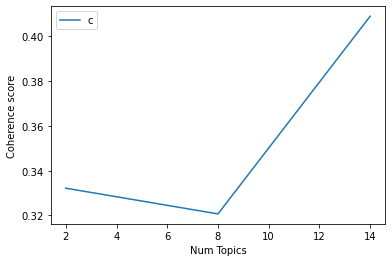

In [21]:
# HOW TO SELECT K (based on https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# ATTENTION!!!! Can take a LONG time to run.
lowerBound = 2
upperBound = 20
step = 6
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=tdm, texts=corpus, start=lowerBound, limit=upperBound, step= step)

# Show graph
x = range(lowerBound, upperBound, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
# The coherence score is decreasing. A higher value should be chosen, because as K increases the probability of having repeated keywords increases.
# ...So, in this case we may choose 8, as there is an inflaction at K=8

#### Insights from the graph: 

This code snippet computes the perplexity of an LDA (Latent Dirichlet Allocation) model. The perplexity is a measure of how well the model predicts a sample or a set of documents. A lower perplexity value indicates better performance. 

Then code calculates the coherence score of an LDA model. Coherence is a measure of the interpretability and consistency of the topics generated by the model. The code creates a CoherenceModel object with the LDA model (lda_model), the corpus, the dictionary, and the coherence measure ('c_v'). The coherence score is obtained using the get_coherence method of the coherence_model_lda object. The code then prints the coherence score.

Finally the code defines a function called compute_coherence_values that computes the coherence values for different numbers of topics in an LDA model. The function takes in a Gensim dictionary, a Gensim corpus, a list of input texts, a limit on the maximum number of topics to consider, and the start and step values for the range of topics.

The coherence score (0.3207052449766973) provides a measure of how coherent and interpretable the topics generated by the model are. A higher coherence score indicates better topic quality. In the context of the graph, a coherence score of 0.32 suggests that the topics might not be highly coherent or distinct.